In [10]:
%load_ext autoreload
%autoreload 2
from load import *
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
import load
import torch
from liftpose.vision_3d import XY_coord_dict, Z_coord_dict

reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)

# decleare data parameters
par_train = {'data_dir' : r'\Users\NeLy\Desktop\mouse_prism\mouse_prism', # change the path 
       'out_dir'        : 'out',
       'train_subjects' : ['G6AE6','G6AE2','G6AE3','G6AE5'],
       'test_subjects'  : ['G6AE1'],
       'actions'        : ['control']}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# Load data
train, train_keypts, _ = load.load_3D(par['data_dir'], subjects=par['train_subjects'], actions=par['actions'])
test,  test_keypts, _ = load.load_3D(par['data_dir'], subjects=par['test_subjects'],  actions=par['actions'])
# project data
train_2d, train_3d = XY_coord_dict(train), Z_coord_dict(train)
test_2d, test_3d  = XY_coord_dict(test), Z_coord_dict(test)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from liftpose.main import train as lp3d_train
lp3d_train(train_2d=train_2d, test_2d=test_2d, train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts, test_keypts=test_keypts,
           roots=par['roots'],
           target_sets=par['target_sets'],
           out_dir=par['out_dir'], training_kwargs={"epochs":10})

[main.py:252]:INFO:Saving pre-processed 2D data at C:\Users\NeLy\Desktop\LiftPose3D\examples\mouse_prism\out\stat_2d.pth.tar
[main.py:271]:INFO:Saving pre-processed 3D data at C:\Users\NeLy\Desktop\LiftPose3D\examples\mouse_prism\out\stat_3d.pth.tar
[main.py:298]:INFO:Starting training model.
[main.py:309]:DEBUG:
==================Options=================
[main.py:310]:DEBUG:{   'batch_size': 64,
    'data_dir': 'C:\\Users\\NeLy\\Desktop\\LiftPose3D\\examples\\mouse_prism\\out',
    'drop_input': 0.0,
    'dropout': 0.5,
    'epochs': 10,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': 'C:\\Users\\NeLy\\Desktop\\LiftPose3D\\examples\\mouse_prism\\out',
    'out_dir': 'C:\\Users\\NeLy\\Desktop\\LiftPose3D\\examples\\mouse_prism\\out',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test'

Epoch 000 | LR  0.00100 | Loss Test  0.00000 | Loss Train  2.73747|: 100%|███████████| 451/451 [00:11<00:00, 39.21it/s]
Epoch 001 | LR  0.00100 | Loss Test  1.13196 | Loss Train  1.17063|: 100%|███████████| 451/451 [00:11<00:00, 38.90it/s]
Epoch 002 | LR  0.00100 | Loss Test  1.08742 | Loss Train  0.93708|: 100%|███████████| 451/451 [00:11<00:00, 39.04it/s]
Epoch 003 | LR  0.00100 | Loss Test  0.98083 | Loss Train  0.88049|: 100%|███████████| 451/451 [00:11<00:00, 39.50it/s]
Epoch 004 | LR  0.00100 | Loss Test  1.08153 | Loss Train  0.85868|: 100%|███████████| 451/451 [00:11<00:00, 38.99it/s]
Epoch 005 | LR  0.00100 | Loss Test  1.05298 | Loss Train  0.83750|: 100%|███████████| 451/451 [00:11<00:00, 39.08it/s]
Epoch 006 | LR  0.00100 | Loss Test  0.95401 | Loss Train  0.81968|: 100%|███████████| 451/451 [00:11<00:00, 39.90it/s]
Epoch 007 | LR  0.00100 | Loss Test  0.93005 | Loss Train  0.80966|: 100%|███████████| 451/451 [00:11<00:00, 38.72it/s]
Epoch 008 | LR  0.00100 | Loss Test  0.9

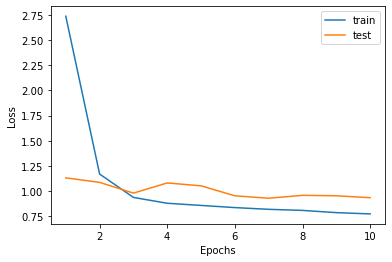

In [12]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

In [13]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:410]:INFO:starting testing in path: out
[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:60]:INFO:total params: 4.23M
[lift.py:66]:INFO:loading ckpt from 'out\ckpt_best.pth.tar'
[lift.py:74]:INFO:ckpt loaded (epoch: 6 | err: 2.1706617718775223)
[lift.py:110]:INFO:Saving results: C:\Users\NeLy\Desktop\LiftPose3D\examples\mouse_prism\out\test_results.pth.tar


In [14]:
from liftpose.postprocess import load_test_results
data = torch.load(par['out_dir'] + "/test_results.pth.tar")
stat_2d, stat_3d = (
    torch.load(par['out_dir'] + "/stat_2d.pth.tar"),
    torch.load(par['out_dir'] + "/stat_3d.pth.tar"),
)
test_3d_gt, test_3d_pred, good_keypts  = load_test_results(data, stat_2d, stat_3d)